In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os


In [2]:
phq_data = pd.read_excel('data/PHQ9_Student_Depression_Dataset_Updated.xlsx')

severity_mapping = {
    'Minimal': 0,
    'Mild': 1,
    'Moderate': 2,
    'Moderately Severe': 3,
    'Severe': 4
}
phq_data['label'] = phq_data['Severity Level'].map(severity_mapping)
text_columns = phq_data.columns[1:9]
phq_data['text'] = phq_data[text_columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

try:
    train_data = pd.read_csv('data/train.tsv', sep='\t')
    dev_data = pd.read_csv('data/dev.tsv', sep='\t')
    test_data = pd.read_csv('data/test.tsv', sep='\t')
    diary_data = pd.concat([train_data, dev_data, test_data])
    diary_data['label'] = diary_data['Label'].str.lower().map(severity_mapping)
    all_data = pd.concat([
        phq_data[['text', 'label']],
        diary_data.rename(columns={'Text data': 'text'})[['text', 'label']]
    ])
except:
    all_data = phq_data[['text', 'label']]


In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class DepressionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [4]:
from sklearn.model_selection import train_test_split

# Drop missing
all_data = all_data.dropna(subset=['text', 'label'])

# Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    all_data['text'].tolist(),
    all_data['label'].tolist(),
    test_size=0.2,
    stratify=all_data['label'],
    random_state=42
)

train_dataset = DepressionDataset(train_texts, train_labels, tokenizer)
val_dataset = DepressionDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [6]:
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 3
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss()


c:\Users\MrsLakshmiKalyani\anaconda3\Lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [7]:
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

def train_one_epoch():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = loss_fn(outputs.logits, batch['labels'])
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    return total_loss / len(train_loader)

def evaluate():
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = loss_fn(outputs.logits, batch['labels'])
            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == batch['labels']).sum().item()
            total += batch['labels'].size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())
    return total_loss / len(val_loader), correct / total, all_preds, all_labels

for epoch in range(3):
    print(f"\nEpoch {epoch + 1}/3")
    train_loss = train_one_epoch()
    val_loss, val_acc, _, _ = evaluate()
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)



Epoch 1/3
Train Loss: 1.4605 | Val Loss: 1.1992 | Val Acc: 0.6200

Epoch 2/3
Train Loss: 1.1327 | Val Loss: 0.9690 | Val Acc: 0.8200

Epoch 3/3
Train Loss: 0.9320 | Val Loss: 0.8940 | Val Acc: 0.9400


In [8]:
_, _, all_preds, all_labels = evaluate()
print(classification_report(all_labels, all_preds, target_names=severity_mapping.keys()))


                   precision    recall  f1-score   support

          Minimal       1.00      1.00      1.00         8
             Mild       1.00      1.00      1.00         9
         Moderate       1.00      0.67      0.80         9
Moderately Severe       1.00      1.00      1.00        10
           Severe       0.82      1.00      0.90        14

         accuracy                           0.94        50
        macro avg       0.96      0.93      0.94        50
     weighted avg       0.95      0.94      0.94        50



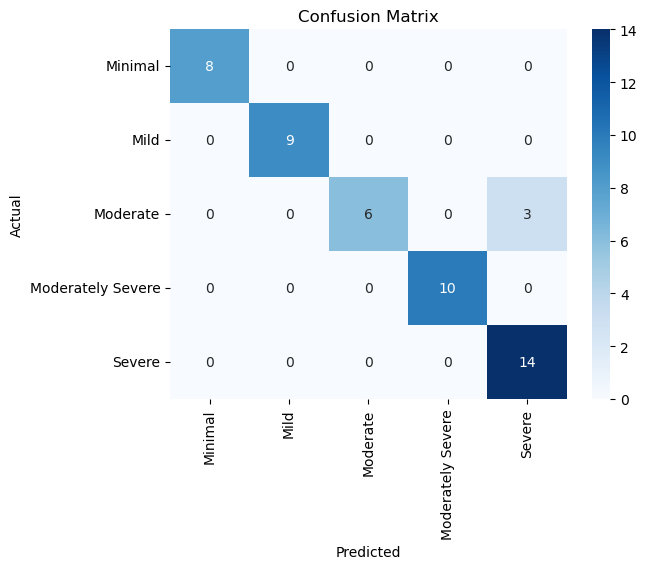

In [9]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=severity_mapping.keys(), yticklabels=severity_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [10]:
def predict(text):
    model.eval()
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()
    return list(severity_mapping.keys())[pred_label], probs.cpu().numpy()

# Example usage
predict("I feel sad and have no interest in daily activities.")


('Moderately Severe',
 array([[0.16947299, 0.18796603, 0.21752451, 0.2333784 , 0.19165808]],
       dtype=float32))

In [11]:
# Save the model and tokenizer
save_path = "bert_depression_model"
os.makedirs(save_path, exist_ok=True)

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"✅ Model and tokenizer saved to: {save_path}")


✅ Model and tokenizer saved to: bert_depression_model
